In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00


In [ ]:
import h5py
import pandas as pd
import numpy as np
import torch_geometric
import scipy
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch_geometric.nn.aggr import LSTMAggregation
import torch_geometric.utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
def data_extraction():
  with h5py.File('/content/drive/MyDrive/Colab Notebooks/ECON_final/scedc.h5', 'r') as file:
      # List all groups in the file
      print("Groups in HDF5 file:")
      for group in file.keys():
          print(group)
      quake = 'quake'
      noise = 'noise'
      quake_group = file[quake]
      noise_group = file[noise]
      # List all datasets in the group
      for group_name in quake_group, noise_group:
        print("\nDatasets in group '{}'".format(group_name))
        for dataset in group_name.keys():
            print(dataset)

      quake_wforms = quake_group['wforms'][()]
      quake_metadata = quake_group['numMeta'][()]
      noise_wforms = noise_group['wforms'][()]
      noise_metadata = noise_group['numMeta'][()]

      return quake_wforms, quake_metadata, noise_wforms, noise_metadata

In [ ]:
def detrend_and_filter(data, fs=100, highpass_freq=2):
    # Apply detrending and high-pass filtering to the data
    detrended_data = scipy.signal.detrend(data, axis=1)

    # High-pass filter design
    sos = scipy.signal.butter(4, highpass_freq, 'hp', fs=fs, output='sos')
    filtered_data = scipy.signal.sosfilt(sos, detrended_data, axis=1)
    return filtered_data

def max_amplitude_normalization(data):
    # Normalize the data by the maximum amplitude across all three components
    max_amplitude = np.max(np.abs(data), axis=(1, 2), keepdims=True)
    normalized_data = data / max_amplitude
    return normalized_data

def z_score_normalization(data):
    # Normalize the data by the standard deviation across all three components
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data


In [ ]:
quake_wforms, quake_metadata, noise_wforms, noise_metadata = data_extraction()

Groups in HDF5 file:
noise
quake
tele

Datasets in group '<HDF5 group "/quake" (5 members)>'
featureNames
featureVals
numMeta
trainTestSplit
wforms

Datasets in group '<HDF5 group "/noise" (7 members)>'
featureNames
featureVals
numMeta
qval
trainTestSplit
trainTestSplit_rand
wforms


In [ ]:
quake_wforms = detrend_and_filter(quake_wforms)
quake_wforms = max_amplitude_normalization(quake_wforms)
quake_wforms = z_score_normalization(quake_wforms)

In [ ]:
labels = ['magnitude', 'hypocentral distance', 'hypocentral depth',
                'log10(snr)', 'unique recordID', 'pickIndex', 'stationLat', 'stationLon',
                'PGA', 'PGV', 'PGD', 'numeric origin time', 'back-azimuth']

quake_metadata_df = pd.DataFrame(quake_metadata.T, columns=labels)
noise_metadata_df = pd.DataFrame(noise_metadata.T, columns=labels)

In [ ]:
noise_metadata_df.describe()

,magnitude,hypocentral distance,hypocentral depth,log10(snr),unique recordID,pickIndex,stationLat,stationLon,PGA,PGV,PGD,numeric origin time,back-azimuth
count,945571.0,945571.0,945571.0,945571.000000,9.455710e+05,945571.000000,945571.0,945571.0,945571.0,945571.0,945571.0,945571.000000,945571.0
mean,0.0,0.0,0.0,1.154523,4.472786e+06,1597.492216,0.0,0.0,0.0,0.0,0.0,736608.170553,0.0
std,0.0,0.0,0.0,1.008899,2.729630e+05,215.414099,0.0,0.0,0.0,0.0,0.0,197.740453,0.0
min,0.0,0.0,0.0,-3.727789,4.000001e+06,777.000000,0.0,0.0,0.0,0.0,0.0,736119.875000,0.0
25%,0.0,0.0,0.0,0.553768,4.236394e+06,1526.000000,0.0,0.0,0.0,0.0,0.0,736519.750000,0.0
50%,0.0,0.0,0.0,1.000808,4.472786e+06,1556.000000,0.0,0.0,0.0,0.0,0.0,736630.812500,0.0
75%,0.0,0.0,0.0,1.489569,4.709178e+06,1586.000000,0.0,0.0,0.0,0.0,0.0,736734.875000,0.0
max,0.0,0.0,0.0,12.190881,4.945571e+06,3618.000000,0.0,0.0,0.0,0.0,0.0,737060.937500,0.0


In [ ]:
quake_metadata_df

,magnitude,hypocentral distance,hypocentral depth,log10(snr),unique recordID,pickIndex,stationLat,stationLon,PGA,PGV,PGD,numeric origin time,back-azimuth
0,7.2,60.178307,9.99,2.254301,1266414.0,2033.0,32.805302,-115.446800,0.0,0.0,0.0,734232.9375,166.138428
1,7.2,67.349365,9.99,3.497228,1266415.0,2001.0,32.758999,-115.731598,0.0,0.0,0.0,734232.9375,141.996353
2,7.2,87.729286,9.99,1.158819,1266416.0,1967.0,32.945099,-115.799896,0.0,0.0,0.0,734232.9375,147.039307
3,7.2,93.251778,9.99,2.678501,1266417.0,3859.0,33.097599,-115.530602,0.0,0.0,0.0,734232.9375,166.221115
4,7.2,93.251778,9.99,3.756822,1266418.0,4038.0,33.097599,-115.530602,0.0,0.0,0.0,734232.9375,166.221115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107313,3.3,95.880280,2.32,0.198049,1373727.0,3148.0,34.690701,-120.446899,0.0,0.0,0.0,736657.3125,114.692207
107314,3.3,99.423866,2.32,2.517575,1373728.0,3251.0,34.106201,-118.455002,0.0,0.0,0.0,736657.3125,284.657776
107315,3.3,99.423866,2.32,1.407093,1373729.0,2982.0,34.106201,-118.455002,0.0,0.0,0.0,736657.3125,284.657776
107316,3.3,99.423866,2.32,1.579433,1373730.0,3051.0,34.106201,-118.455002,0.0,0.0,0.0,736657.3125,284.657776


In [ ]:
grouped_quake_df = quake_metadata_df.groupby(['magnitude', 'numeric origin time'])
grouped_noise_df = noise_metadata_df.groupby(['magnitude', 'numeric origin time'])

In [ ]:
for key, group in grouped_quake_df:
    print(key)
    print(group.head())
    print(group.index.values)
    break

(3.0, 734526.25)
       magnitude  hypocentral distance  hypocentral depth  log10(snr)  \
85614        3.0             28.990103               3.17    3.878331   
85615        3.0             30.093576               3.17    3.045388   

       unique recordID  pickIndex  stationLat  stationLon  PGA  PGV  PGD  \
85614        1352028.0     1005.0   31.045099 -115.466003  0.0  0.0  0.0   
85615        1352029.0     1304.0   31.045099 -115.466003  0.0  0.0  0.0   

       numeric origin time  back-azimuth  
85614            734526.25    302.603027  
85615            734526.25    312.413025  
[85614 85615]


In [ ]:
def prepare_data(grouped_df, wforms, split):

    tot_adj = []
    tot_wforms = []
    tot_targets = []
    tot_edges = []

    if split=='quake':

      for name, group in grouped_df:
          coordinates = np.zeros((len(group),), dtype=object)
          # Extract waveform observations corresponding to current group
          group_index = group.index.values
          tot_wforms.append(wforms[:, group_index, :])
          tot_targets.append(name[0])
          # Extract Lat and Lon values for current group
          for i, (_, row) in enumerate(group.iterrows()):
              coordinates[i] = (row['stationLon'], row['stationLat'])
          coordinates_np = np.array(coordinates)

          # Initialize adjacency matrix for current group
          adj_matrix = np.zeros((len(coordinates_np), len(coordinates_np)))

          # Calculate Euclidean Distance between each seismograph location in current group
          for i in range(len(coordinates_np)):
              for j in range(len(coordinates_np)):
                  adj_matrix[i, j] = np.linalg.norm(np.array(coordinates_np[i]) - np.array(coordinates_np[j]))

          edge_index, _ = torch_geometric.utils.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adj_matrix))
          tot_edges.append(edge_index)
          # Append a copy of the adjacency matrix to the collection
          tot_adj.append(adj_matrix.copy())

    elif split=='noise':

      for name, group in grouped_df:
        coordinates = np.zeros((len(group),), dtype=object)
        # Extract waveform observations corresponding to current group
        group_index = group.index.values
        tot_wforms.append(wforms[:, group_index, :])
        tot_targets.append(name[0])
        coordinates_np = np.array(coordinates)

        # Initialize adjacency matrix for current group
        adj_matrix = np.zeros((len(coordinates_np), len(coordinates_np)))

        edge_index, _ = torch_geometric.utils.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adj_matrix))
        tot_edges.append(edge_index)
        # Append a copy of the adjacency matrix to the collection
        tot_adj.append(adj_matrix.copy())


    return tot_adj, tot_wforms, tot_targets, tot_edges

In [ ]:
quake_adj, quake_wforms, quake_targets, quake_edges = prepare_data(grouped_quake_df, quake_wforms, split='quake')

In [ ]:
noise_adj, noise_wforms, noise_targets, noise_edges = prepare_data(grouped_noise_df, noise_wforms, split='noise')

In [ ]:
for i in range(len(quake_wforms)):
  if len(quake_wforms[i].shape) != 3:
    print(quake_wforms[i].shape)

In [ ]:
def create_dataloader(in_wforms, in_targets, in_edges):
  data_list = []

  for i in range(len(in_wforms)):
    # Reshape the waveform data to have shape (N, 601, 3)
    wforms = in_wforms[i].transpose(1, 2, 0)
    # Create an index tensor for batching
    batch = torch.zeros(wforms.shape[0], dtype=torch.long)
    # Convert waveform data to PyTorch Geometric Data object
    x = torch.tensor(wforms, dtype=torch.float)
    data = Data(x=x, batch=batch, edge_index=in_edges[i], y=torch.tensor(in_targets[i]))
    # Append the Data object to the list
    data_list.append(data)

  return data_list

In [ ]:
quake_data = create_dataloader(quake_wforms, quake_targets, quake_edges)
noise_data = create_dataloader(noise_wforms, noise_targets, noise_edges)
dataset = quake_data + noise_data

In [ ]:
import random

def train_test_split(data_list, test_size=0.2, shuffle=True):
  if shuffle:
    random.shuffle(data_list)
  split = int(len(data_list) * (1 - test_size))
  train_data, test_data = data_list[:split], data_list[split:]
  return train_data, test_data

In [ ]:
quake_train, quake_test = train_test_split(quake_data)
noise_train, noise_test = train_test_split(noise_data)
train, test = train_test_split(dataset)

In [ ]:
for el in train:
  print(el.x.shape[1])
  break

601


#MODEL

In [ ]:
class GNNModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=12):
        super(GNNModel, self).__init__()

        self.conv = GCNConv(input_dim, hidden_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim * 2, 1)  # Combine spatial and temporal features
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Process spatial features
        x_spatial = self.conv(x, edge_index)
        x_spatial = self.pool(x_spatial, dim=1)
        x_spatial = self.relu(x_spatial)

        # Process temporal features
        x_temporal, _ = self.gru(x)
        x_temporal = self.pool(x_temporal, dim=1)
        x_temporal = F.relu(x_temporal)

        # Combine spatial and temporal features
        x_tot = torch.cat([x_spatial, x_temporal], dim=1)

        output = self.fc(x_tot)
        output = output.squeeze(1)

        return torch.mean(output)


In [ ]:
model = GNNModel()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on GPU


In [ ]:
def bbl_loss(output, target, over_penalty=1.0, under_penalty=3.0):
  if output < target:
    return under_penalty*nn.MSELoss()(output, target)
  elif output > target:
    return over_penalty*nn.MSELoss()(output, target)
  else:
    return nn.MSELoss()(output, target)


In [ ]:
# Define loss function and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = bbl_loss
# criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=2)
loss_list = []
train_preds = []
train_targets = []

model.train()
for epoch in range(5):
  running_loss = 0
  for observation in quake_train:
    observation = observation.to(device)
    observation.x = observation.x.reshape(observation.x.size(0), 601, 3) #USE WHEN HANDLING EACH FEATURE SEPARATELY
    optimizer.zero_grad()
    observation.edge_index = observation.edge_index.to(device)
    output = model(observation)
    train_preds.append(output)
    target = observation.y.float().to(device)
    train_targets.append(target)
    target = torch.full_like(output, target)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {running_loss/len(quake_train)}")
  loss_list.append(running_loss/len(quake_train))
  scheduler.step(running_loss)


NameError: name 'bbl_loss' is not defined

In [ ]:
if criterion == bbl_loss:
  text = 'BBLoss'
else:
  text = 'MSE'

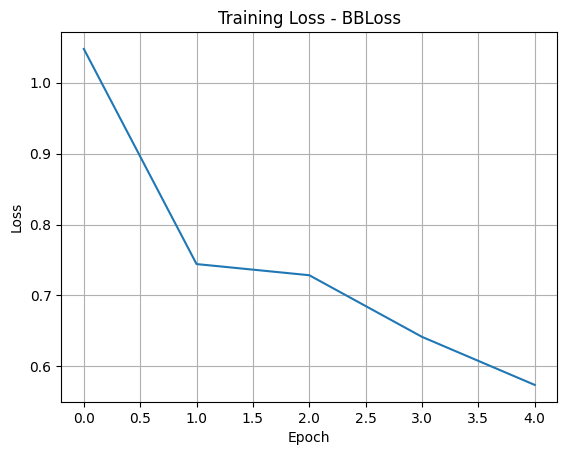

In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Loss - {text}')
plt.grid()
plt.show()

In [ ]:
train_preds = [pred.cpu().item() for pred in train_preds]
train_targets = [target.cpu().item() for target in train_targets]

In [ ]:
# Check lengths of train_preds and train_targets
print(len(train_preds), len(train_targets))

# Trim the longer list to match the shorter one
min_length = min(len(train_preds), len(train_targets))
train_preds_trimmed = train_preds[:min_length]
train_targets_trimmed = train_targets[:min_length]

8070 8070


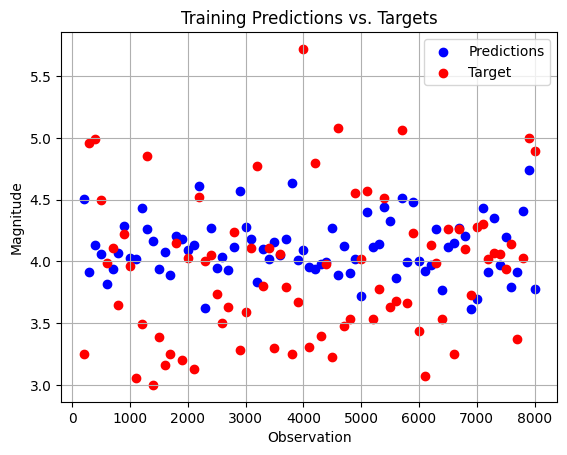

In [ ]:
plt.scatter(range(len(train_preds))[200::100], train_preds[200::100], color='blue', label='Predictions')
plt.scatter(range(len(train_targets))[200::100], train_targets[200::100], color='red', label='Target')
plt.ylabel('Magnitude')
plt.xlabel('Observation')
plt.title('Training Predictions vs. Targets')
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_preds = []
test_targets = []

model.eval()
with torch.no_grad():
    running_loss = 0
    for observation in quake_test:
        observation = observation.to(device)
        # observation.x = observation.x.reshape(observation.x.size(0), -1) #USE WHEN FLATTENING FEATURE DIMENSION
        observation.x = observation.x.reshape(observation.x.size(0), 601, 3) #USE WHEN HANDLING EACH FEATURE SEPARATELY
        output = model(observation)  # Compute output prediction
        test_preds.append(output)

        target = observation.y.float().to(device)
        test_targets.append(target)

        loss = criterion(output, target)
        running_loss += loss.item()
    print(f"Test Loss: {running_loss/len(quake_test)}")

Test Loss: 0.4673310640158582


In [ ]:
test_preds = [pred.cpu().item() for pred in test_preds]
test_targets = [target.cpu().item() for target in test_targets]

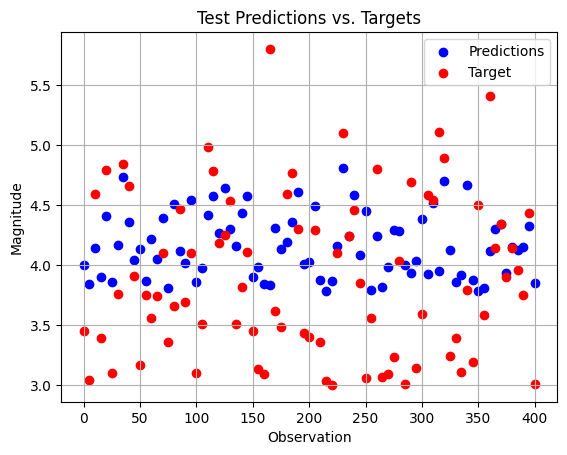

In [ ]:
plt.scatter(range(len(test_preds))[::5], test_preds[::5], color='blue', label='Predictions')
plt.scatter(range(len(test_targets))[::5], test_targets[::5], color='red', label='Target')
plt.ylabel('Magnitude')
plt.xlabel('Observation')
plt.title('Test Predictions vs. Targets')
plt.legend()
plt.grid()
plt.show()